Prepare state space trajectories for a lexical analysis.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [3]:
from collections import Counter, defaultdict
import itertools
from pathlib import Path
import pickle
from typing import Any

import datasets
import matplotlib.pyplot as plt
from mne.decoding import ReceptiveField
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
import torch
import transformers

from src.analysis.state_space import StateSpaceAnalysisSpec
from src.models import get_best_checkpoint
from src.models.integrator import ContrastiveEmbeddingModel, load_or_compute_embeddings

In [4]:
model_dir = "out/ce_model_phoneme_within_word_prefix_6_32"
# model_checkpoint = "out/ce_model_phoneme_6_8/checkpoint-800"
# use a word-level equivalence dataset regardless of model, so that we can look up cohort facts
equiv_dataset_path = "data/timit_equiv_phoneme_6_1.pkl"
timit_corpus_path = "data/timit_phonemes"

output_dir = "."

In [5]:
model = ContrastiveEmbeddingModel.from_pretrained(get_best_checkpoint(model_dir))
model.eval()

ContrastiveEmbeddingModel(
  (rnn): RNNModel(
    (rnn): LSTM(768, 32, batch_first=True)
    (fc): Linear(in_features=32, out_features=32, bias=True)
  )
)

In [6]:
with open(equiv_dataset_path, "rb") as f:
    equiv_dataset = pickle.load(f)

In [8]:
model_representations = load_or_compute_embeddings(model, equiv_dataset, model_dir, equiv_dataset_path)

  0%|          | 0/4740 [00:00<?, ?it/s]

In [9]:
pca = PCA(2).fit(model_representations)
model_representations_pca = pca.transform(model_representations)

In [18]:
timit_corpus = datasets.load_from_disk(timit_corpus_path)

In [19]:
all_phonemes = set(equiv_dataset.class_labels)

In [20]:
cmudict_features = {
    "AA": "low back unrounded",
    "AE": "low front unrounded",
    "AH": "low central unrounded",
    "AO": "low back rounded",
    "AW": "mid back rounded",
    "AY": "high front unrounded",
    "B": "voiced bilabial plosive",
    "CH": "voiceless palato-alveolar affricate",
    "D": "voiced alveolar plosive",
    "DH": "voiced dental fricative",
    "EH": "mid front unrounded",
    "ER": "mid central unrounded",
    "EY": "mid front rounded",
    "F": "voiceless labiodental fricative",
    "G": "voiced velar plosive",
    "HH": "voiceless glottal fricative",
    "IH": "high front unrounded",
    "IY": "high front rounded",
    "JH": "voiced palato-alveolar affricate",
    "K": "voiceless velar plosive",
    "L": "voiced alveolar lateral approximant",
    "M": "voiced bilabial nasal",
    "N": "voiced alveolar nasal",
    "NG": "voiced velar nasal",
    "OW": "mid back rounded",
    "OY": "mid back rounded",
    "P": "voiceless bilabial plosive",
    "R": "voiced alveolar approximant",
    "S": "voiceless alveolar fricative",
    "SH": "voiceless palato-alveolar fricative",
    "T": "voiceless alveolar plosive",
    "TH": "voiceless dental fricative",
    "UH": "high back rounded",
    "UW": "high back rounded",
    "V": "voiced labiodental fricative",
    "W": "voiced labio-velar approximant",
    "Y": "voiced palatal approximant",
    "Z": "voiced alveolar fricative",
    "ZH": "voiced palato-alveolar fricative",
}
cmudict_features = {k: v.split() for k, v in cmudict_features.items()}

In [21]:
all_features = list(sorted(set(itertools.chain(*cmudict_features.values()))))
feature2idx = {f: i for i, f in enumerate(all_features)}

In [22]:
cmudict_feature_idxs = {k: [feature2idx[f] for f in v] for k, v in cmudict_features.items()}

In [23]:
feature_to_phonemes = {f: [k for k, v in cmudict_features.items() if f in v] for f in all_features}

In [24]:
assert all(type(label) == str for label in equiv_dataset.class_labels), "Assumes dataset with phoneme labels"

## Prepare design matrix

In [25]:
frames_by_item = equiv_dataset.hidden_state_dataset.frames_by_item

In [26]:
boundary_event_names = ["item", "word", "phoneme"]
boundary_event_idx = {name: i for i, name in enumerate(boundary_event_names)}
design_matrix = np.zeros((model_representations.shape[0], len(boundary_event_names)))

def update_design_matrix(item, idx):
    start_frame, end_frame = frames_by_item[idx]
    num_frames = end_frame - start_frame
    compression_ratio = num_frames / len(item["input_values"])

    design_matrix[start_frame, boundary_event_idx["item"]] = 1.

    for word in item["word_phonemic_detail"]:
        if len(word) == 0:
            continue

        word_start = start_frame + int(word[0]["start"] * compression_ratio)
        design_matrix[word_start, boundary_event_idx["word"]] = 1.

        for phoneme in word:
            phoneme_start = start_frame + int(phoneme["start"] * compression_ratio)
            design_matrix[phoneme_start, boundary_event_idx["phoneme"]] = 1.

timit_corpus.map(update_design_matrix, with_indices=True)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Dataset({
    features: ['file', 'audio', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id', 'phonemic_detail', 'word_phonetic_detail', 'word_phonemic_detail', 'input_values', 'phone_targets', 'idx'],
    num_rows: 500
})

In [27]:
from src.analysis.trf import estimate_trf_cv

In [28]:
trf_df = estimate_trf_cv(design_matrix, model_representations_pca,
                         [str(idx) for idx in range(model_representations_pca.shape[1])],
                         feature_names=boundary_event_names, tmin=-1, tmax=5, sfreq=1)

Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

In [29]:
trf_df

,fold,level_1,feature,output_name,input_dim,output_dim,lag,time,coef
0,0,0,item,0,0,0,-1,-1.0,0.088522
1,0,1,item,0,0,0,0,0.0,0.096923
2,0,2,item,0,0,0,1,1.0,0.100584
3,0,3,item,0,0,0,2,2.0,0.094985
4,0,4,item,0,0,0,3,3.0,0.102694
...,...,...,...,...,...,...,...,...,...
205,4,37,phoneme,1,2,1,1,1.0,-0.059594
206,4,38,phoneme,1,2,1,2,2.0,-0.074093
207,4,39,phoneme,1,2,1,3,3.0,-0.076377
208,4,40,phoneme,1,2,1,4,4.0,-0.062337


/Users/jon/miniforge3/envs/explore310/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


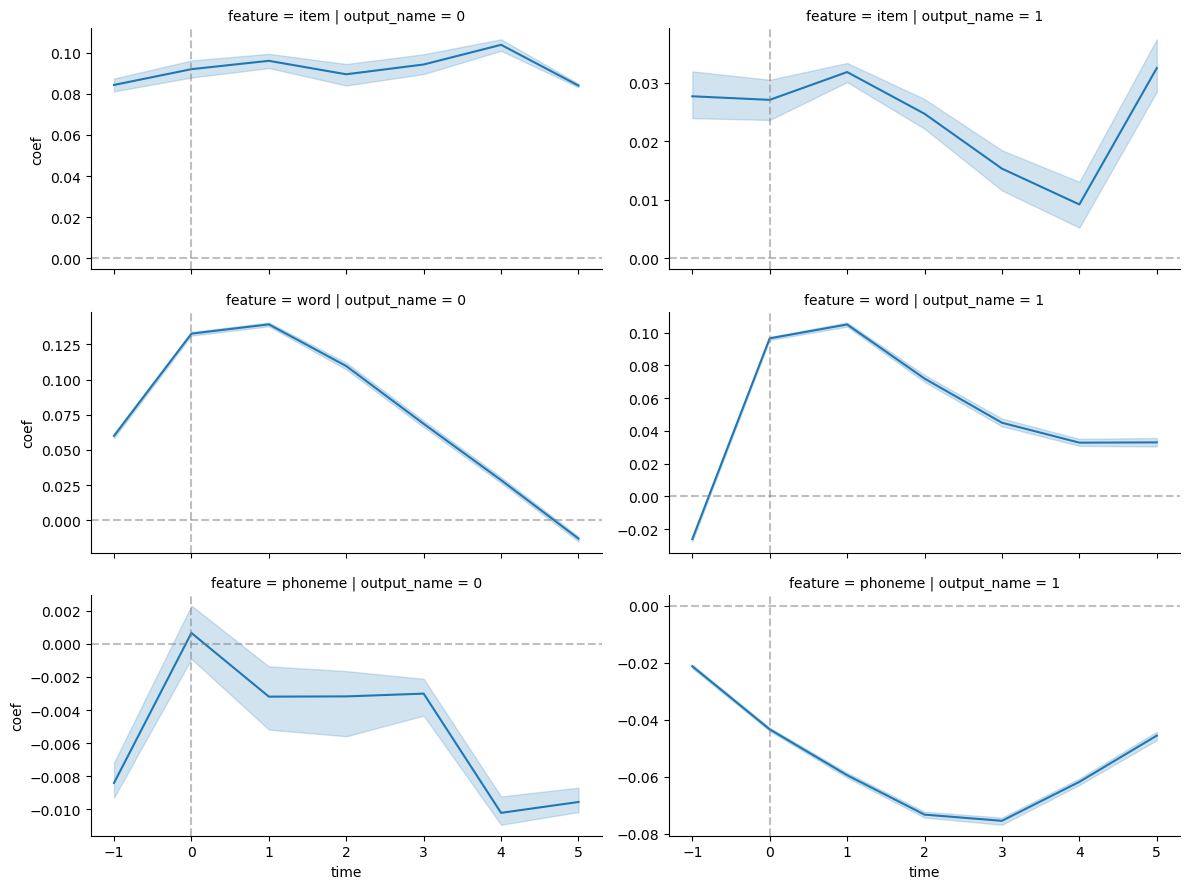

In [30]:
g = sns.FacetGrid(trf_df, row="feature", col="output_name", aspect=2, sharey=False)
g.map(sns.lineplot, "time", "coef")

for ax in g.axes.flat:
    ax.axhline(0, ls="--", color="gray", alpha=0.5)
    ax.axvline(0, ls="--", color="gray", alpha=0.5)

In [ ]:
trf_df.to_csv(Path(output_dir) / "trf_df.csv", index=False)